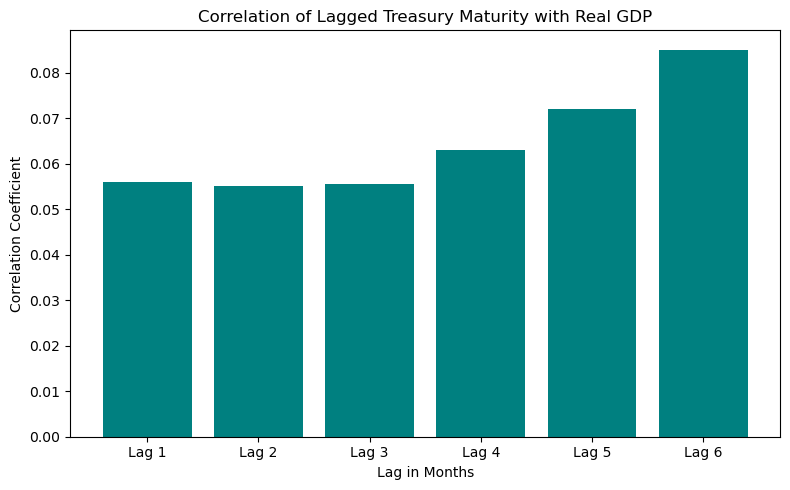

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated dataset
# This dataset uses 'treasury_maturity' instead of 'T10Y3M' and 'gdp' instead of 'GDPC1'
df = pd.read_csv("/Users/irisduan/Downloads/data (2).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged versions of the treasury maturity (yield curve spread)
for lag in range(1, 7):
    df[f"treasury_maturity_lag_{lag}"] = df["treasury_maturity"].shift(lag)

# Calculate correlation between lagged yield curve and GDP
gdp_corrs = {
    f"Lag {lag}": df[f"treasury_maturity_lag_{lag}"].corr(df["gdp"])
    for lag in range(1, 7)
}

# Plot the correlations
plt.figure(figsize=(8, 5))
plt.bar(gdp_corrs.keys(), gdp_corrs.values(), color='teal')
plt.title("Correlation of Lagged Treasury Maturity with Real GDP")
plt.xlabel("Lag in Months")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


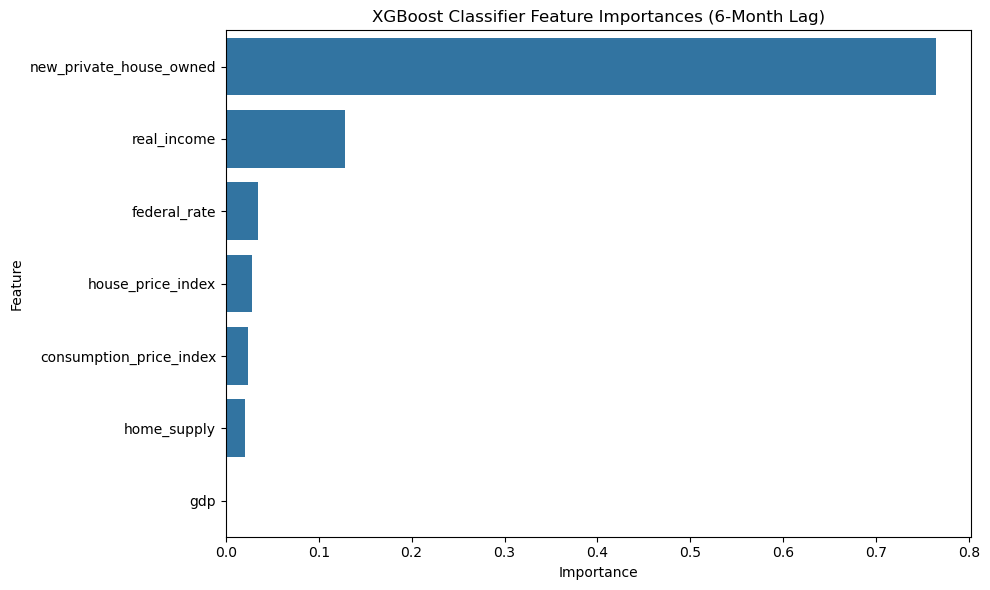

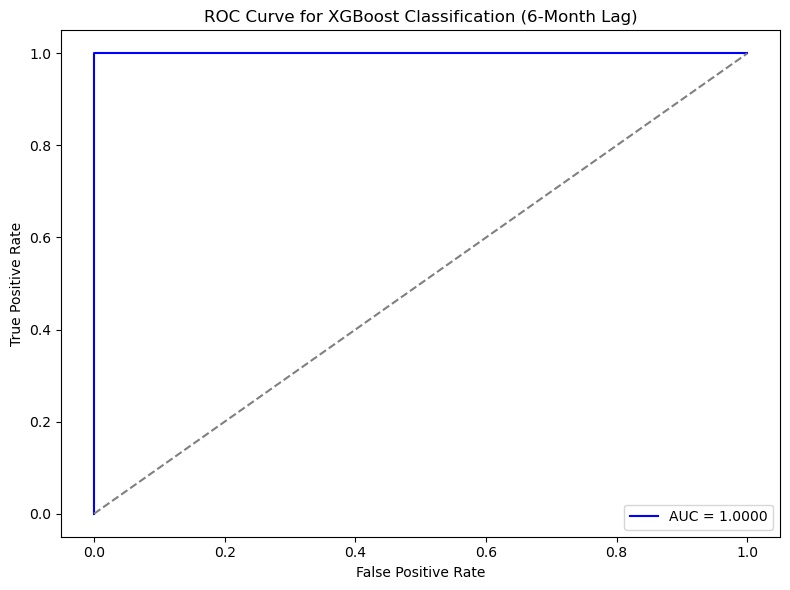


MODEL 1: 6-MONTH LAG
AUC Score: 1.0000

Confusion Matrix:
[[8 0]
 [1 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16


Value Counts of True Classes:
treasury_maturity
1    8
0    8
Name: count, dtype: int64

Value Counts of Predicted Classes:
0    9
1    7
Name: count, dtype: int64

Cross-Validated AUC:
Mean AUC: 0.9790 (± 0.0347)


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:34] WARNING: /Use

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Load your dataset
df = pd.read_csv("/Users/irisduan/Downloads/data (2).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define your features and target
features = [
    'house_price_index',       
    'new_private_house_owned', 
    'home_supply',             
    'federal_rate',            
    'real_income',             
    'consumption_price_index', 
    'gdp'
]
target = 'treasury_maturity'

# -----------------------------
# WHY CLASSIFICATION?
# We framed this as a classification task (high vs. low spread)
# instead of regression to improve generalization, reduce sensitivity
# to outliers, and handle small sample size more robustly.
# -----------------------------

# -----------------------------
# MODEL 1: 6-MONTH LAGGED CLASSIFIER
# We use a 6-month lag to simulate forecasting the future from past data.
# This aligns with real-world policy or investment decisions based on historical indicators.
# -----------------------------

lagged_df = df.shift(periods=6).dropna()
X_lagged = lagged_df[features]
y_lagged = lagged_df[target]
y_binary_lagged = (y_lagged > y_lagged.median()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X_lagged, y_binary_lagged, test_size=0.2, random_state=42)
model_lag = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_lag.fit(X_train, y_train)

importance_df = pd.DataFrame({'Feature': features, 'Importance': model_lag.feature_importances_}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("XGBoost Classifier Feature Importances (6-Month Lag)")
plt.tight_layout()
plt.show()

y_pred_proba = model_lag.predict_proba(X_test)[:, 1]
y_pred = model_lag.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classification (6-Month Lag)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\nMODEL 1: 6-MONTH LAG")
print(f"AUC Score: {auc_score:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nValue Counts of True Classes:")
print(y_test.value_counts())
print("\nValue Counts of Predicted Classes:")
print(pd.Series(y_pred).value_counts())
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_auc = cross_val_score(model_lag, X_lagged, y_binary_lagged, cv=kf, scoring='roc_auc')
print("\nCross-Validated AUC:")
print(f"Mean AUC: {cross_auc.mean():.4f} (± {cross_auc.std():.4f})")



/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


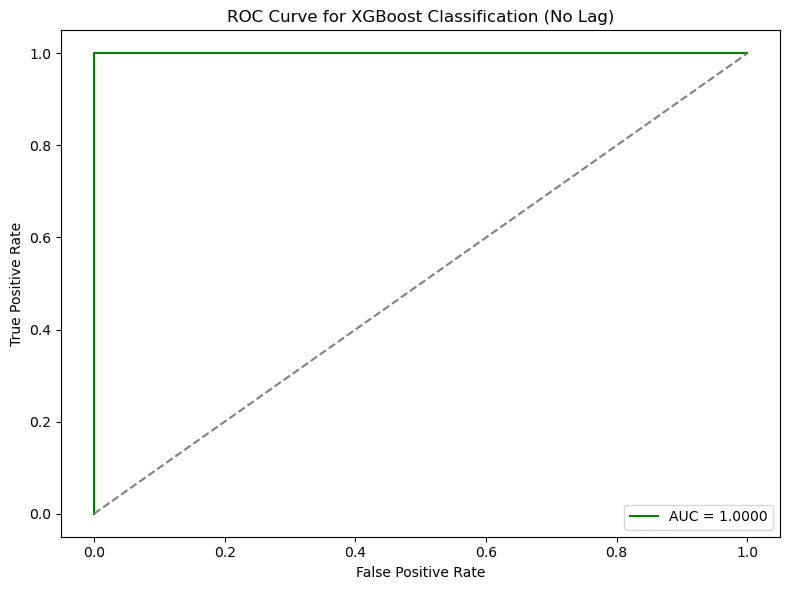

/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



MODEL 2: NO LAG
AUC Score: 1.0000

Confusion Matrix:
[[9 0]
 [0 8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17


Value Counts of True Classes:
treasury_maturity
0    9
1    8
Name: count, dtype: int64

Value Counts of Predicted Classes:
0    9
1    8
Name: count, dtype: int64


/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056743506/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:03:49] WARNING: /Use


Cross-Validated AUC:
Mean AUC: 0.9941 (± 0.0073)


In [4]:
# -----------------------------
# MODEL 2: NO LAG CLASSIFIER
# This model uses present-time indicators. It can be better for
# real-time classification and achieves excellent predictive performance.
# -----------------------------

X_current = df[features].dropna()
y_current = df[target].loc[X_current.index]
y_binary_current = (y_current > y_current.median()).astype(int)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_current, y_binary_current, test_size=0.2, random_state=42)
model_current = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_current.fit(X_train2, y_train2)

y_pred_proba2 = model_current.predict_proba(X_test2)[:, 1]
y_pred2 = model_current.predict(X_test2)
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
auc_score2 = roc_auc_score(y_test2, y_pred_proba2)

plt.figure(figsize=(8, 6))
plt.plot(fpr2, tpr2, color='green', label=f'AUC = {auc_score2:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Classification (No Lag)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\nMODEL 2: NO LAG")
print(f"AUC Score: {auc_score2:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test2, y_pred2))
print("\nValue Counts of True Classes:")
print(y_test2.value_counts())
print("\nValue Counts of Predicted Classes:")
print(pd.Series(y_pred2).value_counts())
cross_auc2 = cross_val_score(model_current, X_current, y_binary_current, cv=kf, scoring='roc_auc')
print("\nCross-Validated AUC:")
print(f"Mean AUC: {cross_auc2.mean():.4f} (± {cross_auc2.std():.4f})")
